# Pipeline Xử lý & Gán nhãn Video (MediaPipe)

## 1. Cài đặt & Imports

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import math
import csv
import time
import os
import glob
from tqdm.notebook import tqdm # Thanh tiến trình
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import google.protobuf

## 2. Các Hàm Tiện ích (Helper Functions)

Dưới đây là các hàm tính toán cốt lõi được sử dụng để trích xuất các đặc trưng hình học (geometric features) từ các keypoint của MediaPipe.

* `calculate_angle(a, b, c)`: Tính góc 3 điểm (phạm vi 0-180 độ), với `b` là đỉnh của góc.
* `calculate_distance(a, b)`: Tính khoảng cách Euclidean 2D tiêu chuẩn giữa hai điểm.
* `get_view(landmarks)`: Xác định góc nhìn của camera (Front, Left, Right) bằng cách so sánh tọa độ Z (độ sâu) của hai vai. Đây là một hàm heuristic quan trọng, vì nó quyết định logic nào sẽ được áp dụng. Ví dụ, chúng ta chỉ có thể phát hiện lỗi "lưng cong" (back) một cách đáng tin cậy khi camera ở góc nhìn nghiêng (Left hoặc Right), không phải từ phía trước (Front).

In [2]:
# Khởi tạo giải pháp MediaPipe
mp_pose = mp.solutions.pose

def calculate_angle(a, b, c):
    """(Đã sửa) Tính góc (0-180 độ) với b là đỉnh."""
    try:
        ang_rad = math.atan2(c['py'] - b['py'], c['px'] - b['px']) - \
                  math.atan2(a['py'] - b['py'], a['px'] - b['px'])
        ang_deg = math.degrees(ang_rad)
        ang_deg = ang_deg % 360
        if ang_deg > 180:
            ang_deg = 360 - ang_deg
        return abs(ang_deg)
    except:
        return 0

def calculate_distance(a, b):
    """Tính khoảng cách Euclidean 2D giữa 2 điểm."""
    try:
        return math.sqrt((a['px'] - b['px'])**2 + (a['py'] - b['py'])**2)
    except:
        return 0

def get_view(landmarks):
    """Xác định góc nhìn của camera dựa trên tọa độ Z của vai."""
    try:
        l_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
        r_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    except:
        return "Unknown"

    l_vis, r_vis = l_shoulder['vis'], r_shoulder['vis']
    l_z, r_z = l_shoulder['z'], r_shoulder['z']
    vis_thresh = 0.7
    z_diff = l_z - r_z
    front_thresh = 0.08
    diag_thresh = 0.25
    view = "Unknown"

    if l_vis > vis_thresh and r_vis > vis_thresh:
        if abs(z_diff) < front_thresh:
            view = "Front"
        elif z_diff > diag_thresh:
            view = "Left"
        elif z_diff < -diag_thresh:
            view = "Right"
        elif z_diff > front_thresh:
            view = "Diagonal Left"
        elif z_diff < -front_thresh:
            view = "Diagonal Right"
    elif l_vis > vis_thresh:
        view = "Right"
    elif r_vis > vis_thresh:
        view = "Left"
        
    return view

## 3. Hàm Xử lý Video Lõi (Core Processing Function)

`analyze_video_frames` là hàm chính thực hiện toàn bộ logic gán nhãn cho *một* video duy nhất.

### Input:
* `pose_detector`: Instance của model MediaPipe (`mp_pose.Pose`) đã được khởi tạo.
* `video_path`: Đường dẫn đến file video cần xử lý.
* `csv_writer`: Một đối tượng `csv.writer` đã mở. Hàm này sẽ ghi trực tiếp các hàng vào file này.
* `video_id`: Một ID định danh duy nhất (thường là tên file) cho video này.

### Output:
* Hàm này **ghi trực tiếp** các hàng (frames) đã được gán nhãn vào `csv_writer`.
* Nó cũng trả về một danh sách các nhãn lỗi của các rep đã hoàn thành (dùng để thống kê ở cell cuối).

### Logic chính:
1.  **Đọc Video**: Lặp qua từng frame của video, resize về `TARGET_WIDTH` để chuẩn hóa.
2.  **Detect Keypoints**: Chạy `pose_detector.process()` trên frame để trích xuất 33 keypoint.
3.  **Tính toán Góc & Heuristics**:
    * Áp dụng `get_view()` để xác định góc nhìn.
    * Tính `avg_shoulder_angle` (góc nâng vai), đây là chỉ số chính để đếm rep.
    * Áp dụng các luật (heuristics) để kiểm tra lỗi cho *từng frame* (lưng cong, tay quá cao, nhún vai) và lưu vào `frame_errors`.
4.  **State Machine (Đếm Rep)**:
    * Sử dụng hai ngưỡng (`UP_THRESHOLD` và `DOWN_THRESHOLD`) dựa trên `avg_shoulder_angle`.
    * Hệ thống theo dõi trạng thái `state` ("up" hoặc "down").
    * Một rep được coi là "In Progress" (đang thực hiện) khi góc vai vượt qua `UP_THRESHOLD`.
5.  **Gán nhãn frame**:
    * **Logic gán nhãn**: frame lỗi (ví dụ: `label_back`) trong rep đó > 20% tổng số frame của rep, thì *tất cả các frame* trong rep đó sẽ được gán nhãn `label_back=1`.
    * Cuối cùng, frame trong `rep_data_log` được ghi vào file CSV.

In [3]:
def analyze_video_frames(pose_detector, video_path, csv_writer, video_id):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []

    TARGET_WIDTH = 1200
    
    # --- CÁC BIẾN TRẠNG THÁI ---
    frame_id = 0
    rep_id_counter = 0
    state = "down"
    view = "Initializing"
    
    # --- NGƯỠNG (THRESHOLDS) ---
    UP_THRESHOLD = 80
    DOWN_THRESHOLD = 40
    
    # --- BIẾN LOGIC REP ---
    current_rep_frames = 0
    rep_state = "N/A" 
    
    # Thay đổi: rep_data_log sẽ chứa cả Landmarks VÀ Labels của frame đó
    rep_data_log = [] 

    # Biến heuristic cho Rep Summary (để return thống kê nếu cần)
    completed_rep_stats = [] 

    while cap.isOpened():
        success, image = cap.read()
        if not success: break
        frame_id += 1

        # --- Xử lý hình ảnh ---
        h, w = image.shape[:2]
        scale = TARGET_WIDTH / w
        dim = (TARGET_WIDTH, int(h * scale))
        image_resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        h, w = image_resized.shape[:2]
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        results = pose_detector.process(image_rgb)

        # --- Khởi tạo biến lỗi cho Frame hiện tại ---
        # Mặc định là 0 (Đúng), nếu sai sẽ bật lên 1
        frame_errors = {"back": 0, "high": 0, "shrug": 0}
        
        lm_coords = {}
        lm_data_row_base = [frame_id]
        avg_shoulder_angle = 0 

        if results.pose_landmarks:
            landmarks_raw = results.pose_landmarks.landmark
            for id, lm in enumerate(landmarks_raw):
                cx, cy = int(lm.x * w), int(lm.y * h)
                lm_coords[id] = {'x': lm.x, 'y': lm.y, 'z': lm.z, 'vis': lm.visibility, 'px': cx, 'py': cy}
                lm_data_row_base.extend([lm.x, lm.y, lm.z, lm.visibility])
            
            view = get_view(lm_coords) # Giả định hàm này đã có
            
            # === TÍNH TOÁN GÓC ===
            try:
                la = calculate_angle(lm_coords[23], lm_coords[11], lm_coords[13])
                ra = calculate_angle(lm_coords[24], lm_coords[12], lm_coords[14])
                avg_shoulder_angle = (la + ra) / 2
            except: 
                avg_shoulder_angle = 0

            # === LOGIC HEURISTIC (CHECK LỖI TỪNG FRAME) ===
            # 1. Lưng cong
            if view != "Front":
                try:
                    side_idx, ear_idx, shoulder_idx = (23, 7, 11) if "Left" in view else (24, 8, 12)
                    back_angle = calculate_angle(lm_coords[ear_idx], lm_coords[shoulder_idx], lm_coords[side_idx])
                    if back_angle < 165: frame_errors["back"] = 1
                except: pass
            
            # 2. Tay quá cao
            if avg_shoulder_angle > 110: frame_errors["high"] = 1 
            
            # 3. Nhún vai
            try:
                l_dist = abs(lm_coords[7]['py'] - lm_coords[11]['py'])
                r_dist = abs(lm_coords[8]['py'] - lm_coords[12]['py'])
                shoulder_width = calculate_distance(lm_coords[11], lm_coords[12])
                if shoulder_width > 0:
                    shrug_ratio = (l_dist + r_dist) / (2 * shoulder_width)
                    if shrug_ratio < 0.15: frame_errors["shrug"] = 1
            except: pass

            # === STATE MACHINE ===
            if avg_shoulder_angle > UP_THRESHOLD:
                state = "up"
                if rep_state != "In Progress":
                    rep_state = "In Progress"
                    rep_data_log = [] # Reset log cho rep mới
                    current_rep_frames = 0
            
            elif avg_shoulder_angle < DOWN_THRESHOLD:
                prev_state = state
                state = "down"
                
                # KẾT THÚC REP
                if prev_state == "up" and rep_state == "In Progress":
                    rep_id_counter += 1
                    
                    # Lọc nhiễu: Chỉ ghi nếu rep đủ dài
                    if current_rep_frames > 5: 
                        # --- WRITE LOGIC ĐÃ SỬA ĐỔI ---
                        # Duyệt qua từng frame đã lưu trong rep này và ghi vào CSV
                        # Lúc này frame_packet đã chứa sẵn nhãn sai/đúng của chính frame đó
                        for frame_packet in rep_data_log:
                            # Cấu trúc row: [VideoID, RepID, FrameID, Landmarks..., ErrBack, ErrHigh, ErrShrug]
                            row = [video_id, rep_id_counter] + frame_packet
                            csv_writer.writerow(row)
                        
                        # (Optional) Lưu thống kê để return ra ngoài hàm nếu cần
                        completed_rep_stats.append({
                            "rep_id": rep_id_counter,
                            "frames": current_rep_frames
                        })
                    
                    # Reset trạng thái
                    rep_state = "Done"
                    rep_data_log = []

            # === DATA COLLECTION (QUAN TRỌNG) ===
            # Nếu đang trong Rep, lưu data VÀ trạng thái lỗi ngay lập tức
            if rep_state == "In Progress":
                current_rep_frames += 1
                
                # Tạo list nhãn lỗi của frame hiện tại: [0, 1, 0] ví dụ vậy
                current_labels = [frame_errors["back"], frame_errors["high"], frame_errors["shrug"]]
                
                # Nối landmarks + labels thành một dòng dữ liệu hoàn chỉnh
                full_frame_data = lm_data_row_base + current_labels
                
                # Đẩy vào buffer chờ kết thúc rep mới ghi
                rep_data_log.append(full_frame_data)
            
    cap.release()
    return completed_rep_stats

## 4. Chạy Xử lý Hàng loạt (Batch Execution)

In [4]:
# === 1. ĐỊNH NGHĨA ĐƯỜNG DẪN ===
VIDEO_FOLDER = '../data/lateral raise' 
OUTPUT_DIR = 'output'
SUMMARY_CSV_NAME = 'summary_lateral_raise.csv'
SUMMARY_CSV_PATH = os.path.join(OUTPUT_DIR, SUMMARY_CSV_NAME)

# === 2. TẠO THƯ MỤC OUTPUT ===
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Đã tạo/xác nhận thư mục output tại: {os.path.abspath(OUTPUT_DIR)}")

# === 3. TÌM TẤT CẢ VIDEO ===
video_extensions = ["*.mp4", "*.avi", "*.mov", "*.mkv"]
video_files = []
for ext in video_extensions:
    video_files.extend(glob.glob(os.path.join(VIDEO_FOLDER, ext)))
print(f"Tìm thấy tổng cộng {len(video_files)} video.")

# === 4. KHỞI TẠO MEDIAPIPE (1 LẦN) ===
pose_detector = mp_pose.Pose(min_detection_confidence=0.5, 
                             min_tracking_confidence=0.5,
                             model_complexity=1)

# === 5. XỬ LÝ HÀNG LOẠT (GHI VÀO 1 FILE) ===

# Tạo header cho file CSV tổng
landmarks_header = []
for i in range(33):
    landmarks_header.extend([f'lm_{i}_x', f'lm_{i}_y', f'lm_{i}_z', f'lm_{i}_vis'])

# THAY ĐỔI QUAN TRỌNG Ở ĐÂY:
# Thay vì ['rep_label'], ta thêm 4 cột label riêng biệt
label_headers = ['label_back', 'label_high', 'label_shrug']

csv_header = ['video_id', 'rep_id', 'frame_id'] + landmarks_header + label_headers

# List để lưu tất cả nhãn của các rep (dùng để vẽ biểu đồ)
all_rep_labels = []

if not video_files:
    print(f"CẢNH BÁO: Không tìm thấy video nào trong '{VIDEO_FOLDER}'.")
else:
    # Mở file CSV TỔNG HỢP (chỉ 1 lần)
    with open(SUMMARY_CSV_PATH, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(csv_header) # Viết header 1 lần duy nhất
        
        print(f"Đang ghi vào file summary: {SUMMARY_CSV_PATH}")
        
        # Dùng tqdm để tạo thanh tiến trình
        for video_path in tqdm(video_files, desc="Đang xử lý các video"):
            
            # Dùng tên file (không có đuôi) làm video_id
            video_id = os.path.splitext(os.path.basename(video_path))[0]
            
            # print(f"\n[BẮT ĐẦU] Xử lý: {video_id}")
            
            # Gọi hàm xử lý, truyền csv_writer và video_id
            start_time = time.time()
            labels_from_this_video = analyze_video_frames(
                pose_detector, video_path, csv_writer, video_id
            )
            all_rep_labels.extend(labels_from_this_video)
            end_time = time.time()
            
            # print(f"[HOÀN THÀNH] {video_id} trong {end_time - start_time:.2f} giây")

# === 6. DỌN DẸP MODEL ===
pose_detector.close()
print(f"\n--- Xử lý hàng loạt hoàn tất! ---")
print(f"Tổng số {len(all_rep_labels)} rep đã được xử lý và ghi vào file summary.")

Đã tạo/xác nhận thư mục output tại: e:\Learning\Collage\2026\hocki1\PBL 6\notebooks\output
Tìm thấy tổng cộng 44 video.
Đang ghi vào file summary: output\summary_lateral_raise.csv


Đang xử lý các video:   0%|          | 0/44 [00:00<?, ?it/s]


--- Xử lý hàng loạt hoàn tất! ---
Tổng số 151 rep đã được xử lý và ghi vào file summary.


## 5. Phân tích & Trực quan hóa Kết quả

Đọc file summary từ: output/summary_lateral_raise.csv

--- THỐNG KÊ TRÊN TỔNG SỐ 5941 FRAMES ---
label_back     2621
label_high      586
label_shrug      51
dtype: int64

Số frame 'Correct' (Không lỗi): 2895


C:\Users\PC\AppData\Local\Temp\ipykernel_9728\2349196735.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Error Type', y='Count', data=plot_data, palette='viridis')


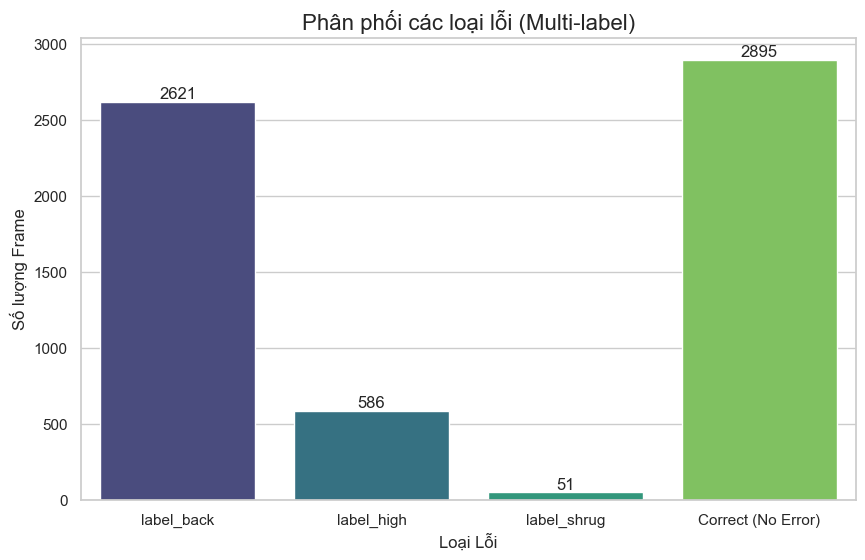


5 Dòng dữ liệu mẫu (Labels):
      label_back  label_high  label_shrug
3188           1           0            0
2440           0           0            0
2294           1           0            0
4483           0           0            0
2795           0           1            0


In [5]:
# Đường dẫn file (Đảm bảo giống cell trên)
SUMMARY_CSV_PATH = 'output/summary_lateral_raise.csv'

print(f"Đọc file summary từ: {SUMMARY_CSV_PATH}")

try:
    df = pd.read_csv(SUMMARY_CSV_PATH)

    if df.empty:
        print("File summary rỗng. Hãy kiểm tra lại bước xử lý video (Cell 25).")
    else:
        # Danh sách các cột nhãn mới
        label_cols = ['label_back', 'label_high', 'label_shrug']
        
        # Kiểm tra xem file CSV có đúng định dạng mới không
        if not all(col in df.columns for col in label_cols):
            print(f"LỖI: File CSV chưa có các cột đa nhãn: {label_cols}")
            print("Các cột hiện có:", df.columns.tolist())
        else:
            total_frames = len(df)
            print(f"\n--- THỐNG KÊ TRÊN TỔNG SỐ {total_frames} FRAMES ---")
            
            # 1. Đếm số lượng frame bị lỗi cho từng loại
            # (Lưu ý: Một frame có thể bị nhiều lỗi cùng lúc)
            error_counts = df[label_cols].sum().sort_values(ascending=False)
            print(error_counts)
            
            # 2. Đếm số frame "Sạch" (Correct - không dính lỗi nào)
            # Logic: Tổng tất cả các cột lỗi = 0
            correct_frames = df[df[label_cols].sum(axis=1) == 0].shape[0]
            print(f"\nSố frame 'Correct' (Không lỗi): {correct_frames}")
            
            # === VẼ BIỂU ĐỒ ===
            plt.figure(figsize=(10, 6))
            
            # Tạo dữ liệu để vẽ
            plot_data = error_counts.to_frame(name='Count').reset_index()
            plot_data.columns = ['Error Type', 'Count']
            
            # Thêm cột Correct vào biểu đồ để so sánh
            new_row = pd.DataFrame({'Error Type': ['Correct (No Error)'], 'Count': [correct_frames]})
            plot_data = pd.concat([plot_data, new_row], ignore_index=True)
            
            # Vẽ Bar Chart
            sns.set_theme(style="whitegrid")
            ax = sns.barplot(x='Error Type', y='Count', data=plot_data, palette='viridis')
            
            ax.set_title('Phân phối các loại lỗi (Multi-label)', fontsize=16)
            ax.set_ylabel('Số lượng Frame', fontsize=12)
            ax.set_xlabel('Loại Lỗi', fontsize=12)
            
            # Hiển thị số liệu trên đầu cột
            for i in ax.containers:
                ax.bar_label(i,)
                
            plt.show()

            # === KIỂM TRA MẪU DỮ LIỆU ===
            print("\n5 Dòng dữ liệu mẫu (Labels):")
            print(df[label_cols].sample(5))

except FileNotFoundError:
    print(f"Không tìm thấy file: {SUMMARY_CSV_PATH}")
except Exception as e:
    print(f"Lỗi không mong muốn: {e}")